In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf
import networkx as nx

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Part 2: Spatial Interaction models

## III. Models and calibration

#### Preprocessing

In [3]:
# Read in data.
df_flows = pd.read_csv('london_flows.csv')

In [4]:
# Delete data rows containing "Battersea".
df_cleaned = df_flows[~df_flows['station_origin'].str.contains("Battersea", na=False) & ~df_flows['station_destination'].str.contains("Battersea", na=False)]

In [5]:
# Delete data rows with internal flows.
df_cleaned = df_cleaned[df_cleaned['station_origin'] != df_cleaned['station_destination']].copy()

In [6]:
df_cleaned

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167
...,...,...,...,...,...,...
61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549
61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361
61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451
61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554


In [7]:
Orig = 'population'
Dest = 'jobs'
Dist = 'distance'

In [8]:
# Get the log of variables.
df_cleaned['log_Oi'] = np.log(df_cleaned[Orig])
df_cleaned['log_Dj'] = np.log(df_cleaned[Dest])
df_cleaned['log_cost'] = np.log(df_cleaned[Dist]) # Inverse power cost function.

# Negative exponential cost function.
df_cleaned['cost'] = df_cleaned[Dist]

In [9]:
# View data.
print(df_cleaned.head())

  station_origin station_destination  flows  population   jobs     distance  \
0     Abbey Road   Bank and Monument      0         599  78549  8131.525097   
1     Abbey Road             Beckton      1         599    442  8510.121774   
2     Abbey Road           Blackwall      3         599    665  3775.448872   
3     Abbey Road        Canary Wharf      1         599  58772  5086.514220   
4     Abbey Road        Canning Town     37         599  15428  2228.923167   

     log_Oi     log_Dj  log_cost         cost  
0  6.395262  11.271478  9.003504  8131.525097  
1  6.395262   6.091310  9.049012  8510.121774  
2  6.395262   6.499787  8.236275  3775.448872  
3  6.395262  10.981421  8.534348  5086.514220  
4  6.395262   9.643939  7.709274  2228.923167  


In [10]:
# "Goodness-of-fit" functions.
def CalcRSquared(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

#### Check Data Characteristics

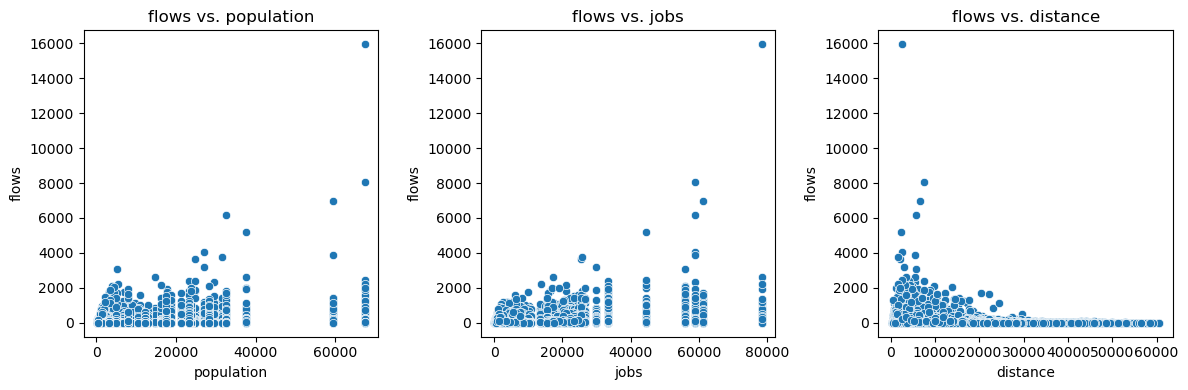

In [11]:
# Plot scatter plots of flows versus other columns
plt.figure(figsize=(12, 4))

columns_to_plot = ['population', 'jobs', 'distance']

for i, column in enumerate(columns_to_plot):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=df_cleaned[column], y=df_cleaned['flows'])
    plt.title(f'flows vs. {column}')
    plt.xlabel(column)
    plt.ylabel('flows')

plt.tight_layout()
plt.show()

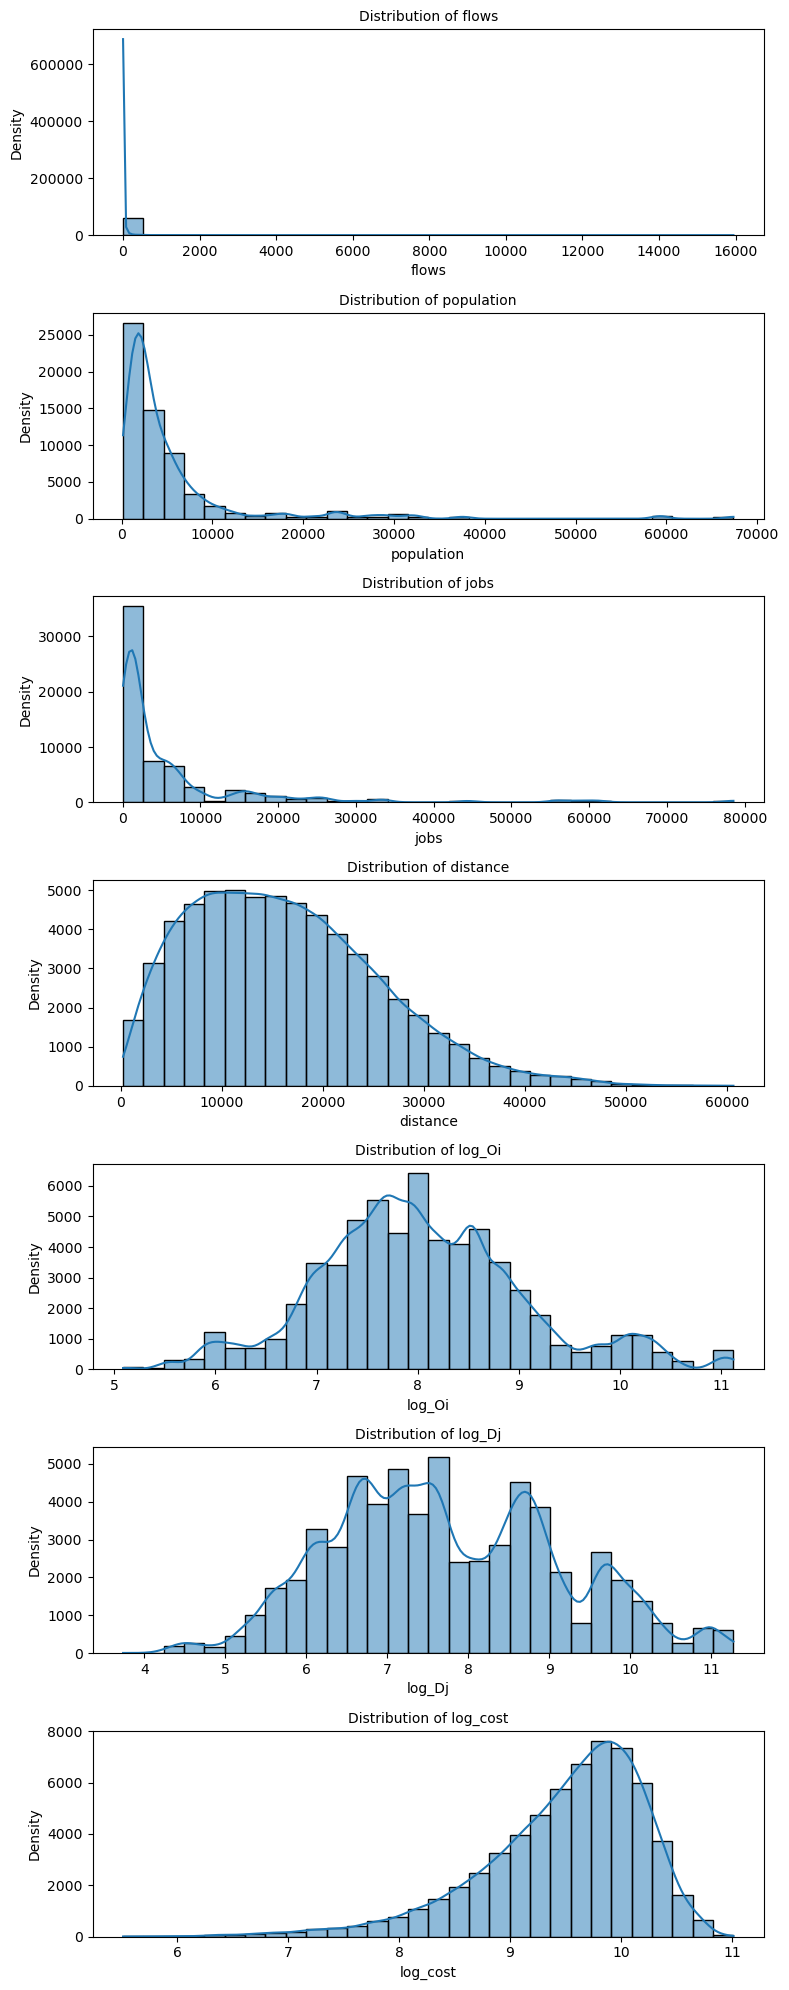

In [12]:
# Plot the distribution of data.
fig, axes = plt.subplots(7, 1, figsize=(8, 20))

columns_to_plot = ['flows', 'population', 'jobs', 'distance', 'log_Oi', 'log_Dj', 'log_cost']

for i, col in enumerate(columns_to_plot):
    sns.histplot(df_cleaned[col], bins=30, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}', fontsize=10)
    axes[i].set_ylabel('Density')

plt.tight_layout()
plt.show()

#### Unconstrained Model

In [13]:
# Unconstrained model with inverse power cost function.
formula_unconstrained_pow = 'flows ~ log_Oi + log_Dj + log_cost'

unconstrained_pow = smf.glm(formula=formula_unconstrained_pow, data=df_cleaned, family=sm.families.Poisson()).fit()

# Assign the parameter values.
K_unconstrained_pow = unconstrained_pow.params['Intercept']
alpha_unconstrained_pow = unconstrained_pow.params['log_Oi']
gamma_unconstrained_pow = unconstrained_pow.params['log_Dj']
beta_unconstrained_pow = -unconstrained_pow.params['log_cost']

# Calculate the result.
df_cleaned['unconstrained_pow'] = np.round(
    np.exp(
        (alpha_unconstrained_pow * df_cleaned['log_Oi']) +
        (gamma_unconstrained_pow * df_cleaned['log_Dj']) -
        (beta_unconstrained_pow * df_cleaned['log_cost']) +
        K_unconstrained_pow
    ), 0).astype(int)

In [14]:
# Unconstrained model with negative exponential cost function.
formula_unconstrained_exp = 'flows ~ log_Oi + log_Dj + cost'

unconstrained_exp = smf.glm(formula=formula_unconstrained_exp, data=df_cleaned, family=sm.families.Poisson()).fit()

# Assign the parameter values.
K_unconstrained_exp = unconstrained_exp.params['Intercept']
alpha_unconstrained_exp = unconstrained_exp.params['log_Oi']
gamma_unconstrained_exp = unconstrained_exp.params['log_Dj']
beta_unconstrained_exp = -unconstrained_exp.params['cost']

# Calculate the result.
df_cleaned['unconstrained_exp'] = np.round(
    np.exp(
        (alpha_unconstrained_exp * df_cleaned['log_Oi']) +
        (gamma_unconstrained_exp * df_cleaned['log_Dj']) -
        (beta_unconstrained_exp * df_cleaned['cost']) +
        K_unconstrained_exp
    ), 0).astype(int)

In [15]:
# Test the "Goodness-of-fit".
r_squared_pow = CalcRSquared(df_cleaned["flows"], df_cleaned["unconstrained_pow"])
rmse_pow = CalcRMSE(df_cleaned["flows"], df_cleaned["unconstrained_pow"])

r_squared_exp = CalcRSquared(df_cleaned["flows"], df_cleaned["unconstrained_exp"])
rmse_exp = CalcRMSE(df_cleaned["flows"], df_cleaned["unconstrained_exp"])

In [16]:
# Create a df to save results.
data_fit_goodness = {
    'Model': ['unconstrained_pow', 'unconstrained_exp'],
    'R-Squared': [r_squared_pow, r_squared_exp],
    'RMSE': [rmse_pow, rmse_exp]
}

df_fit_goodness = pd.DataFrame(data_fit_goodness)
df_fit_goodness.set_index('Model', inplace=True)
print(df_fit_goodness)

                   R-Squared     RMSE
Model                                
unconstrained_pow   0.321190  108.334
unconstrained_exp   0.362248  105.723


#### Origin Constrained Model

In [17]:
# Origin constrained model with inverse power cost function.
formula_origin_pow = 'flows ~ station_origin + log_Dj + log_cost -1'

origin_pow = smf.glm(formula=formula_origin_pow, data=df_cleaned, family=sm.families.Poisson()).fit()

# Assign the parameter values.
alpha_origin_pow_i = pd.DataFrame(origin_pow.params).reset_index().rename(columns={0: 'alpha_i', 'index': 'coef'})
gamma_origin_pow = origin_pow.params['log_Dj']
beta_origin_pow = -origin_pow.params['log_cost']

In [18]:
# Clean column names.
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    alpha_origin_pow_i["coef"] = alpha_origin_pow_i["coef"].str.replace(x, "",regex=True)

# Join data.
df_cleaned = df_cleaned.merge(alpha_origin_pow_i, left_on="station_origin", right_on="coef", how = "left")
df_cleaned.drop(columns = ["coef"], inplace = True)
df_cleaned.rename(columns={'alpha_i': 'alpha_i_pow'}, inplace=True)

In [19]:
# Calculate the result.
df_cleaned['origin_pow'] = np.round(
    np.exp(
        df_cleaned['alpha_i_pow'] + 
        (gamma_origin_pow * df_cleaned['log_Dj']) -
        (beta_origin_pow * df_cleaned['log_cost'])
    ), 0).astype(int)

In [20]:
df_cleaned

,station_origin,station_destination,flows,population,jobs,distance,log_Oi,log_Dj,log_cost,cost,unconstrained_pow,unconstrained_exp,alpha_i_pow,origin_pow
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,8131.525097,50,62,3.250242,55
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,8510.121774,1,1,3.250242,1
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3775.448872,2,3,3.250242,3
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,5086.514220,53,66,3.250242,66
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,2228.923167,32,32,3.250242,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,13401.795549,22,23,6.905590,121
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,8701.454361,42,51,6.905590,259
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,9536.720451,5,7,6.905590,32
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,5355.248554,14,18,6.905590,98


In [21]:
# Origin constrained model with negative exponential cost function.
formula_origin_exp = 'flows ~ station_origin + log_Dj + cost -1'

origin_exp = smf.glm(formula=formula_origin_exp, data=df_cleaned, family=sm.families.Poisson()).fit()

# Assign the parameter values.
alpha_origin_exp_i = pd.DataFrame(origin_exp.params).reset_index().rename(columns={0: 'alpha_i', 'index': 'coef'})
gamma_origin_exp = origin_exp.params['log_Dj']
beta_origin_exp = -origin_exp.params['cost']

In [22]:
# Clean column names.
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    alpha_origin_exp_i["coef"] = alpha_origin_exp_i["coef"].str.replace(x, "",regex=True)

# Join data.
df_cleaned = df_cleaned.merge(alpha_origin_exp_i, left_on="station_origin", right_on="coef", how = "left")
df_cleaned.drop(columns = ["coef"], inplace = True)
df_cleaned.rename(columns={'alpha_i': 'alpha_i_exp'}, inplace=True)

In [23]:
# Calculate the result.
df_cleaned['origin_exp'] = np.round(
    np.exp(
        df_cleaned['alpha_i_exp'] + 
        (gamma_origin_exp * df_cleaned['log_Dj']) -
        (beta_origin_exp * df_cleaned['cost'])
    ), 0).astype(int)

In [24]:
df_cleaned

,station_origin,station_destination,flows,population,jobs,distance,log_Oi,log_Dj,log_cost,cost,unconstrained_pow,unconstrained_exp,alpha_i_pow,origin_pow,alpha_i_exp,origin_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,8131.525097,50,62,3.250242,55,-2.914322,78
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,8510.121774,1,1,3.250242,1,-2.914322,1
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3775.448872,2,3,3.250242,3,-2.914322,4
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,5086.514220,53,66,3.250242,66,-2.914322,99
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,2228.923167,32,32,3.250242,49,-2.914322,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,13401.795549,22,23,6.905590,121,0.518041,99
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,8701.454361,42,51,6.905590,259,0.518041,295
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,9536.720451,5,7,6.905590,32,0.518041,36
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,5355.248554,14,18,6.905590,98,0.518041,125


In [25]:
# Test the "Goodness-of-fit".
r_squared_pow = CalcRSquared(df_cleaned["flows"], df_cleaned["origin_pow"])
rmse_pow = CalcRMSE(df_cleaned["flows"], df_cleaned["origin_pow"])

r_squared_exp = CalcRSquared(df_cleaned["flows"], df_cleaned["origin_exp"])
rmse_exp = CalcRMSE(df_cleaned["flows"], df_cleaned["origin_exp"])

In [26]:
# Save results.
df_fit_goodness.loc['origin_pow', :] = [r_squared_pow, rmse_pow]
df_fit_goodness.loc['origin_exp', :] = [r_squared_exp, rmse_exp]

print(df_fit_goodness)

                   R-Squared     RMSE
Model                                
unconstrained_pow   0.321190  108.334
unconstrained_exp   0.362248  105.723
origin_pow          0.388276  102.893
origin_exp          0.468065   96.263


#### Destination Constrained Model

In [27]:
# Destination constrained model with inverse power cost function.
formula_destination_pow = 'flows ~ log_Oi + station_destination + log_cost -1'

destination_pow = smf.glm(formula=formula_destination_pow, data=df_cleaned, family=sm.families.Poisson()).fit()

# Assign the parameter values.
alpha_destination_pow = destination_pow.params['log_Oi']
gamma_destination_pow_j = pd.DataFrame(destination_pow.params).reset_index().rename(columns={0: 'gamma_j', 'index': 'coef'})
beta_destination_pow = -destination_pow.params['log_cost']

In [28]:
# Clean column names.
to_repl = ["(station_destination)", "\[", "\]"]
for x in to_repl:
    gamma_destination_pow_j["coef"] = gamma_destination_pow_j["coef"].str.replace(x, "",regex=True)

# Join data.
df_cleaned = df_cleaned.merge(gamma_destination_pow_j, left_on="station_origin", right_on="coef", how = "left")
df_cleaned.drop(columns = ["coef"], inplace = True)
df_cleaned.rename(columns={'gamma_j': 'gamma_j_pow'}, inplace=True)

In [29]:
# Calculate the result.
df_cleaned['destination_pow'] = np.round(
    np.exp(
        (alpha_destination_pow * df_cleaned['log_Oi']) +
        df_cleaned['gamma_j_pow'] -
        (beta_destination_pow * df_cleaned['log_cost'])
    ), 0).astype(int)

In [30]:
df_cleaned

,station_origin,station_destination,flows,population,jobs,distance,log_Oi,log_Dj,log_cost,cost,unconstrained_pow,unconstrained_exp,alpha_i_pow,origin_pow,alpha_i_exp,origin_exp,gamma_j_pow,destination_pow
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,8131.525097,50,62,3.250242,55,-2.914322,78,1.108254,1
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,8510.121774,1,1,3.250242,1,-2.914322,1,1.108254,1
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3775.448872,2,3,3.250242,3,-2.914322,4,1.108254,2
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,5086.514220,53,66,3.250242,66,-2.914322,99,1.108254,2
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,2228.923167,32,32,3.250242,49,-2.914322,56,1.108254,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,13401.795549,22,23,6.905590,121,0.518041,99,4.458413,165
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,8701.454361,42,51,6.905590,259,0.518041,295,4.458413,218
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,9536.720451,5,7,6.905590,32,0.518041,36,4.458413,205
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,5355.248554,14,18,6.905590,98,0.518041,125,4.458413,296


In [31]:
# Destination constrained model with negative exponential cost function.
formula_destination_exp = 'flows ~ log_Oi + station_destination + cost -1'

destination_exp = smf.glm(formula=formula_destination_exp, data=df_cleaned, family=sm.families.Poisson()).fit()

# Assign the parameter values.
alpha_destination_exp = destination_exp.params['log_Oi']
gamma_destination_exp_j = pd.DataFrame(destination_exp.params).reset_index().rename(columns={0: 'gamma_j', 'index': 'coef'})
beta_destination_exp = -destination_exp.params['cost']

In [32]:
# Clean column names.
to_repl = ["(station_destination)", "\[", "\]"]
for x in to_repl:
    gamma_destination_exp_j["coef"] = gamma_destination_exp_j["coef"].str.replace(x, "",regex=True)

# Join data.
df_cleaned = df_cleaned.merge(gamma_destination_exp_j, left_on="station_origin", right_on="coef", how = "left")
df_cleaned.drop(columns = ["coef"], inplace = True)
df_cleaned.rename(columns={'gamma_j': 'gamma_j_exp'}, inplace=True)

In [33]:
# Calculate the result.
df_cleaned['destination_exp'] = np.round(
    np.exp(
        (alpha_destination_exp * df_cleaned['log_Oi']) +
        df_cleaned['gamma_j_exp'] -
        (beta_destination_exp * df_cleaned['cost'])
    ), 0).astype(int)

In [34]:
df_cleaned

,station_origin,station_destination,flows,population,jobs,distance,log_Oi,log_Dj,log_cost,cost,unconstrained_pow,unconstrained_exp,alpha_i_pow,origin_pow,alpha_i_exp,origin_exp,gamma_j_pow,destination_pow,gamma_j_exp,destination_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,8131.525097,50,62,3.250242,55,-2.914322,78,1.108254,1,-3.191658,2
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,8510.121774,1,1,3.250242,1,-2.914322,1,1.108254,1,-3.191658,2
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3775.448872,2,3,3.250242,3,-2.914322,4,1.108254,2,-3.191658,3
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,5086.514220,53,66,3.250242,66,-2.914322,99,1.108254,2,-3.191658,2
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,2228.923167,32,32,3.250242,49,-2.914322,56,1.108254,3,-3.191658,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,13401.795549,22,23,6.905590,121,0.518041,99,4.458413,165,-0.100378,145
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,8701.454361,42,51,6.905590,259,0.518041,295,4.458413,218,-0.100378,232
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,9536.720451,5,7,6.905590,32,0.518041,36,4.458413,205,-0.100378,213
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,5355.248554,14,18,6.905590,98,0.518041,125,4.458413,296,-0.100378,323


In [35]:
# Test the "Goodness-of-fit".
r_squared_pow = CalcRSquared(df_cleaned["flows"], df_cleaned["destination_pow"])
rmse_pow = CalcRMSE(df_cleaned["flows"], df_cleaned["destination_pow"])

r_squared_exp = CalcRSquared(df_cleaned["flows"], df_cleaned["destination_exp"])
rmse_exp = CalcRMSE(df_cleaned["flows"], df_cleaned["destination_exp"])

In [36]:
# Save results.
df_fit_goodness.loc['destination_pow', :] = [r_squared_pow, rmse_pow]
df_fit_goodness.loc['destination_exp', :] = [r_squared_exp, rmse_exp]

print(df_fit_goodness)

                   R-Squared     RMSE
Model                                
unconstrained_pow   0.321190  108.334
unconstrained_exp   0.362248  105.723
origin_pow          0.388276  102.893
origin_exp          0.468065   96.263
destination_pow     0.061962  205.072
destination_exp     0.075363  187.410


#### Doubly Constrained Model

In [37]:
# Doubly constrained model with inverse power cost function.
formula_doubly_pow = 'flows ~ station_origin + station_destination + log_cost -1'

doubly_pow = smf.glm(formula=formula_doubly_pow, data=df_cleaned, family=sm.families.Poisson()).fit()

# Calculate the result.
df_cleaned["doubly_pow"] = np.round(doubly_pow.mu)

In [38]:
df_cleaned

,station_origin,station_destination,flows,population,jobs,distance,log_Oi,log_Dj,log_cost,cost,...,unconstrained_exp,alpha_i_pow,origin_pow,alpha_i_exp,origin_exp,gamma_j_pow,destination_pow,gamma_j_exp,destination_exp,doubly_pow
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,8131.525097,...,62,3.250242,55,-2.914322,78,1.108254,1,-3.191658,2,55.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,8510.121774,...,1,3.250242,1,-2.914322,1,1.108254,1,-3.191658,2,2.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3775.448872,...,3,3.250242,3,-2.914322,4,1.108254,2,-3.191658,3,3.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,5086.514220,...,66,3.250242,66,-2.914322,99,1.108254,2,-3.191658,2,77.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,2228.923167,...,32,3.250242,49,-2.914322,56,1.108254,3,-3.191658,3,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,13401.795549,...,23,6.905590,121,0.518041,99,4.458413,165,-0.100378,145,257.0
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,8701.454361,...,51,6.905590,259,0.518041,295,4.458413,218,-0.100378,232,152.0
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,9536.720451,...,7,6.905590,32,0.518041,36,4.458413,205,-0.100378,213,20.0
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,5355.248554,...,18,6.905590,98,0.518041,125,4.458413,296,-0.100378,323,115.0


In [39]:
# Doubly constrained model with negative exponential cost function.
formula_doubly_exp = 'flows ~ station_origin + station_destination + cost -1'

doubly_exp = smf.glm(formula=formula_doubly_exp, data=df_cleaned, family=sm.families.Poisson()).fit()

# Calculate the result.
df_cleaned["doubly_exp"] = np.round(doubly_exp.mu)

In [40]:
df_cleaned

,station_origin,station_destination,flows,population,jobs,distance,log_Oi,log_Dj,log_cost,cost,...,alpha_i_pow,origin_pow,alpha_i_exp,origin_exp,gamma_j_pow,destination_pow,gamma_j_exp,destination_exp,doubly_pow,doubly_exp
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,8131.525097,...,3.250242,55,-2.914322,78,1.108254,1,-3.191658,2,55.0,77.0
1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,8510.121774,...,3.250242,1,-2.914322,1,1.108254,1,-3.191658,2,2.0,3.0
2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3775.448872,...,3.250242,3,-2.914322,4,1.108254,2,-3.191658,3,3.0,4.0
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,5086.514220,...,3.250242,66,-2.914322,99,1.108254,2,-3.191658,2,77.0,112.0
4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,2228.923167,...,3.250242,49,-2.914322,56,1.108254,3,-3.191658,3,45.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,13401.795549,...,6.905590,121,0.518041,99,4.458413,165,-0.100378,145,257.0,185.0
61409,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,8701.454361,...,6.905590,259,0.518041,295,4.458413,218,-0.100378,232,152.0,176.0
61410,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,9536.720451,...,6.905590,32,0.518041,36,4.458413,205,-0.100378,213,20.0,27.0
61411,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,5355.248554,...,6.905590,98,0.518041,125,4.458413,296,-0.100378,323,115.0,132.0


In [41]:
# Test the "Goodness-of-fit".
r_squared_pow = CalcRSquared(df_cleaned["flows"], df_cleaned["doubly_pow"])
rmse_pow = CalcRMSE(df_cleaned["flows"], df_cleaned["doubly_pow"])

r_squared_exp = CalcRSquared(df_cleaned["flows"], df_cleaned["doubly_exp"])
rmse_exp = CalcRMSE(df_cleaned["flows"], df_cleaned["doubly_exp"])

In [42]:
# Save results.
df_fit_goodness.loc['doubly_pow', :] = [r_squared_pow, rmse_pow]
df_fit_goodness.loc['doubly_exp', :] = [r_squared_exp, rmse_exp]

print(df_fit_goodness)

                   R-Squared     RMSE
Model                                
unconstrained_pow   0.321190  108.334
unconstrained_exp   0.362248  105.723
origin_pow          0.388276  102.893
origin_exp          0.468065   96.263
destination_pow     0.061962  205.072
destination_exp     0.075363  187.410
doubly_pow          0.407685  101.335
doubly_exp          0.497843   93.401


In [43]:
df_fit_goodness.to_csv('df_fit_goodness.csv', index=False)

In [44]:
def get_beta_parameters(model_list, model_names):
    data = []
    
    for model, name in zip(model_list, model_names):
        beta = -model.params[-1]
        data.append([name, beta])
    
    df = pd.DataFrame(data, columns=["Model name", "Beta"])
    return df

models = [
    unconstrained_pow, 
    unconstrained_exp, 
    origin_pow, 
    origin_exp, 
    destination_pow, 
    destination_exp, 
    doubly_pow, 
    doubly_exp
]

model_names = [
    "Unconstrained Power",
    "Unconstrained Exponential",
    "Origin Power",
    "Origin Exponential",
    "Destination Power",
    "Destination Exponential",
    "Doubly Constrained Power",
    "Doubly Constrained Exponential"
]

df_beta_parameters = get_beta_parameters(models, model_names)

print(df_beta_parameters)

                       Model name      Beta
0             Unconstrained Power  0.622802
1       Unconstrained Exponential  0.000090
2                    Origin Power  0.878119
3              Origin Exponential  0.000153
4               Destination Power  0.635148
5         Destination Exponential  0.000100
6        Doubly Constrained Power  0.909632
7  Doubly Constrained Exponential  0.000154


In [45]:
df_beta_parameters.to_csv('df_beta_parameters.csv', index=False)

Some test

In [46]:
df_cleaned_check = df_cleaned.copy()

# Calculate the difference between the 'doubly_exp' column and the 'flows' column.
df_cleaned_check['difference'] = df_cleaned_check['doubly_exp'] - df_cleaned_check['flows']

In [47]:
# Sort by 'difference'
df_sorted = df_cleaned_check.sort_values(by='difference', ascending=False)

# Extract specified columns
columns_of_interest = ['station_origin', 'station_destination', 'difference']
df_extracted = df_sorted[columns_of_interest]

# Extract the first 10 rows after sorting
top10 = df_extracted.head(10)
bottom10 = df_extracted.tail(10)

# Merge the first and last 10 rows of data
df_final = pd.concat([top10, bottom10], axis=0)

df_final

,station_origin,station_destination,difference
32584,London Bridge,Bank and Monument,2517.0
56116,Waterloo,Victoria,2165.0
32282,Liverpool Street,Bank and Monument,2109.0
49857,Stratford,Bank and Monument,1860.0
8488,Canada Water,Bank and Monument,1784.0
32709,London Bridge,Liverpool Street,1679.0
61381,Woolwich Arsenal,Canary Wharf,1504.0
54613,Victoria,Bank and Monument,1477.0
56015,Waterloo,Liverpool Street,1263.0
55988,Waterloo,Holborn,1204.0


## IV. Scenarios

We will use Origin-Constrained Model to simulate scenario changes. We assume that changing one's residential address is more difficult and that residential addresses remain unchanged. For example, if the number of jobs changes, some residents may move to other locations to work instead of moving. Likewise, when transportation costs change, residents may travel further or closer to work.

### IV.1. Scenario A

Assume that Canary Wharf has a 50% decrease in jobs after Brexit.

In [71]:
df_cleaned_A = df_cleaned.copy()

# Halve 'jobs' in Canary Wharf
df_cleaned_A.loc[df_cleaned_A['station_destination'] == 'Canary Wharf', 'jobs'] /= 2

In [79]:
# Test.
df_cleaned_TEST = df_cleaned.copy()

# Calculate the values of destination attractiveness terms and cost function terms.
Dj_gamma = df_cleaned_TEST["jobs"]**gamma_origin_exp
f_c = np.exp((-beta_origin_exp)*df_cleaned_TEST["distance"])
# Then multiply.
df_cleaned_TEST["Ai1"] = Dj_gamma * f_c
# Then sum terms of the same origin.
A_i = pd.DataFrame(df_cleaned_TEST.groupby(["station_origin"])["Ai1"].agg(np.sum))
# Then take the reciprocal.
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)

# Write the A_i values back into the dataframe.
df_cleaned_TEST = df_cleaned_TEST.merge(A_i, left_on="station_origin", right_index=True, how="left")

# To check everything works, recreate the original estimates.
df_cleaned_TEST["scenario_A_0"] = df_cleaned_TEST["A_i"]*df_cleaned_TEST["population"]*Dj_gamma*f_c
# Round.
df_cleaned_TEST["scenario_A_0"] = round(df_cleaned_TEST["scenario_A_0"], 0)
# Check
df_cleaned_TEST[["origin_exp", "scenario_A_0"]]

,origin_exp,scenario_A_0
0,78,78.0
1,1,1.0
2,4,4.0
3,99,99.0
4,56,56.0
...,...,...
61408,99,99.0
61409,295,295.0
61410,36,36.0
61411,125,125.0


In [76]:
# Calculate the values of destination attractiveness terms and cost function terms.
Dj_gamma = df_cleaned_A["jobs"]**gamma_origin_exp
f_c = np.exp((-beta_origin_exp)*df_cleaned_A["distance"])
# Then multiply.
df_cleaned_A["Ai1"] = Dj_gamma * f_c
# Then sum terms of the same origin.
A_i = pd.DataFrame(df_cleaned_A.groupby(["station_origin"])["Ai1"].agg(np.sum))
# Then take the reciprocal.
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)

# Write the A_i values back into the dataframe.
df_cleaned_A = df_cleaned_A.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [77]:
# Calculate new flows.
df_cleaned_A["scenario_A_1"] = df_cleaned_A["A_i"]*df_cleaned_A["population"]*Dj_gamma*f_c

df_cleaned_A["scenario_A_1"] = round(df_cleaned_A["scenario_A_1"], 0)

In [80]:
pivot_0 = df_cleaned_A.pivot_table(values ="origin_exp", index="station_origin", columns = "station_destination", aggfunc=np.sum, margins=True)
pivot_0

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100


In [81]:
pivot_A = df_cleaned_A.pivot_table(values ="scenario_A_1", index="station_origin", columns = "station_destination", aggfunc=np.sum, margins=True)
pivot_A

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3750.0
Aldgate,NaN,NaN,1.0,NaN,38.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2886.0
Aldgate East,NaN,NaN,1.0,41.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4860.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3102.0


In [83]:
# Check the extent of flows redistribution changes.
r_squared_A = CalcRSquared(df_cleaned_A["origin_exp"], df_cleaned_A["scenario_A_1"])
rmse_A = CalcRMSE(df_cleaned_A["origin_exp"], df_cleaned_A["scenario_A_1"])
print(r_squared_A)
print(rmse_A)

0.9865795498598867
9.463


### IV.2. Scenario B

First we will simulate a slight change.

In [90]:
# Parameters increased by 10%.
new_beta_1 = beta_origin_exp*1.1

In [91]:
df_cleaned_B_1 = df_cleaned.copy()

In [92]:
# Calculate the values of destination attractiveness terms and cost function terms.
Dj_gamma = df_cleaned_B_1["jobs"]**gamma_origin_exp
f_c = np.exp((-new_beta_1)*df_cleaned_B_1["distance"])
# Then multiply.
df_cleaned_B_1["Ai1"] = Dj_gamma * f_c
# Then sum terms of the same origin.
A_i = pd.DataFrame(df_cleaned_B_1.groupby(["station_origin"])["Ai1"].agg(np.sum))
# Then take the reciprocal.
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)

# Write the A_i values back into the dataframe.
df_cleaned_B_1 = df_cleaned_B_1.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [93]:
# Calculate new flows.
df_cleaned_B_1["scenario_B_1"] = df_cleaned_B_1["A_i"]*df_cleaned_B_1["population"]*Dj_gamma*f_c

df_cleaned_B_1["scenario_B_1"] = round(df_cleaned_B_1["scenario_B_1"], 0)

In [94]:
pivot_B_1= df_cleaned_B_1.pivot_table(values ="scenario_B_1", index="station_origin", columns = "station_destination", aggfunc=np.sum, margins=True)
pivot_B_1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,600.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,12.0,11.0,NaN,15.0,0.0,NaN,15.0,...,12.0,3.0,2.0,21.0,NaN,0.0,NaN,0.0,NaN,3738.0
Aldgate,NaN,NaN,1.0,NaN,39.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,0.0,NaN,2884.0
Aldgate East,NaN,NaN,1.0,42.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,2.0,2.0,NaN,1.0,NaN,0.0,NaN,3166.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,40.0,52.0,NaN,NaN,NaN,NaN,29.0,...,2.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4865.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,18.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3089.0


In [95]:
# Check the extent of flows redistribution changes.
r_squared_B_1 = CalcRSquared(df_cleaned_B_1["origin_exp"], df_cleaned_B_1["scenario_B_1"])
rmse_B_1 = CalcRMSE(df_cleaned_B_1["origin_exp"], df_cleaned_B_1["scenario_B_1"])
print(r_squared_B_1)
print(rmse_B_1)

0.9981054383227765
3.987


Then we try larger changes.

In [96]:
# 10 times the parameters.
new_beta_2 = beta_origin_exp*10

In [97]:
df_cleaned_B_2 = df_cleaned.copy()

In [98]:
# Calculate the values of destination attractiveness terms and cost function terms.
Dj_gamma = df_cleaned_B_2["jobs"]**gamma_origin_exp
f_c = np.exp((-new_beta_2)*df_cleaned_B_2["distance"])
# Then multiply.
df_cleaned_B_2["Ai1"] = Dj_gamma * f_c
# Then sum terms of the same origin.
A_i = pd.DataFrame(df_cleaned_B_2.groupby(["station_origin"])["Ai1"].agg(np.sum))
# Then take the reciprocal.
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)

# Write the A_i values back into the dataframe.
df_cleaned_B_2 = df_cleaned_B_2.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [99]:
# Calculate new flows.
df_cleaned_B_2["scenario_B_2"] = df_cleaned_B_2["A_i"]*df_cleaned_B_2["population"]*Dj_gamma*f_c

df_cleaned_B_2["scenario_B_2"] = round(df_cleaned_B_2["scenario_B_2"], 0)

In [100]:
pivot_B_2 = df_cleaned_B_2.pivot_table(values ="scenario_B_2", index="station_origin", columns = "station_destination", aggfunc=np.sum, margins=True)
pivot_B_2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,2.0,0.0,NaN,0.0,...,0.0,0.0,0.0,1.0,NaN,0.0,NaN,0.0,NaN,3742.0
Aldgate,NaN,NaN,0.0,NaN,87.0,NaN,NaN,0.0,NaN,4.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,2881.0
Aldgate East,NaN,NaN,0.0,117.0,NaN,NaN,0.0,0.0,NaN,3.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


In [101]:
# Check the extent of flows redistribution changes.
r_squared_B_2 = CalcRSquared(df_cleaned_B_2["origin_exp"], df_cleaned_B_2["scenario_B_2"])
rmse_B_2 = CalcRMSE(df_cleaned_B_2["origin_exp"], df_cleaned_B_2["scenario_B_2"])
print(r_squared_B_2)
print(rmse_B_2)

0.12158498747337408
244.576


### IV.3. Discuss

In [104]:
# Create an undirected graph of the London Underground.
G = nx.read_graphml('london_updated.graphml')

In [105]:
# Since coords tuples are stored as string, need to convert them back to tuples using eval().
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [106]:
# To check node attributes.
list(G.nodes(data = True))[0]

('Stratford', {'coords': (538524.7855297636, 184373.34100822973)})

In [107]:
# Function for adding coordinate.
def add_station_coords(df, G):
    stations_coords = pd.DataFrame(list(G.nodes(data='coords')), columns=['station', 'coords'])
    
    df_with_coords = df.merge(stations_coords, left_on='station_origin', right_on='station', how='left')
    df_with_coords.rename(columns={'coords': 'origin_coords'}, inplace=True)
    df_with_coords.drop(columns=['station'], inplace=True)

    df_with_coords = df_with_coords.merge(stations_coords, left_on='station_destination', right_on='station', how='left')
    df_with_coords.rename(columns={'coords': 'destination_coords'}, inplace=True)
    df_with_coords.drop(columns=['station'], inplace=True)

    return df_with_coords

In [108]:
df_cleaned_A_coords = add_station_coords(df_cleaned_A, G)

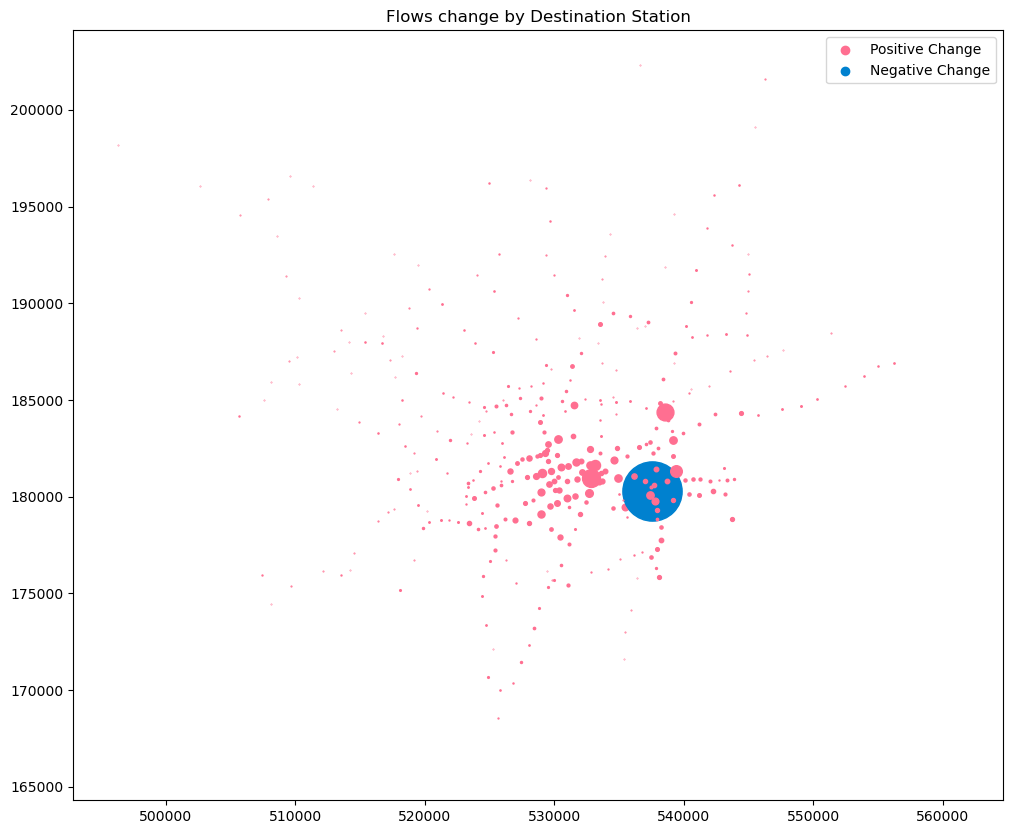

In [130]:
# Make a difference between the destination inflow before and after the scenario changes, and then visualize it.
df_cleaned_A_coords['change_A'] = df_cleaned_A_coords['scenario_A_1'] - df_cleaned_A_coords['origin_exp']

grouped = df_cleaned_A_coords.groupby('station_destination').agg(
    total_change_A=('change_A', 'sum'),
    destination_coords=('destination_coords', 'first')
)

plt.figure(figsize=(12, 10))

for idx, row in grouped.iterrows():
    total_change = row['total_change_A']
    coords = row['destination_coords']
    color = '#FF6F91' if total_change > 0 else '#0081CF'
    size = abs(total_change)*0.1

    plt.scatter(coords[0], coords[1], color=color, s=size)

plt.title('Flows change by Destination Station')
plt.grid(False)

plt.scatter([], [], color='#FF6F91', label='Positive Change')
plt.scatter([], [], color='#0081CF', label='Negative Change')
plt.legend()

plt.show()

In [121]:
df_cleaned_B_1_coords = add_station_coords(df_cleaned_B_1, G)

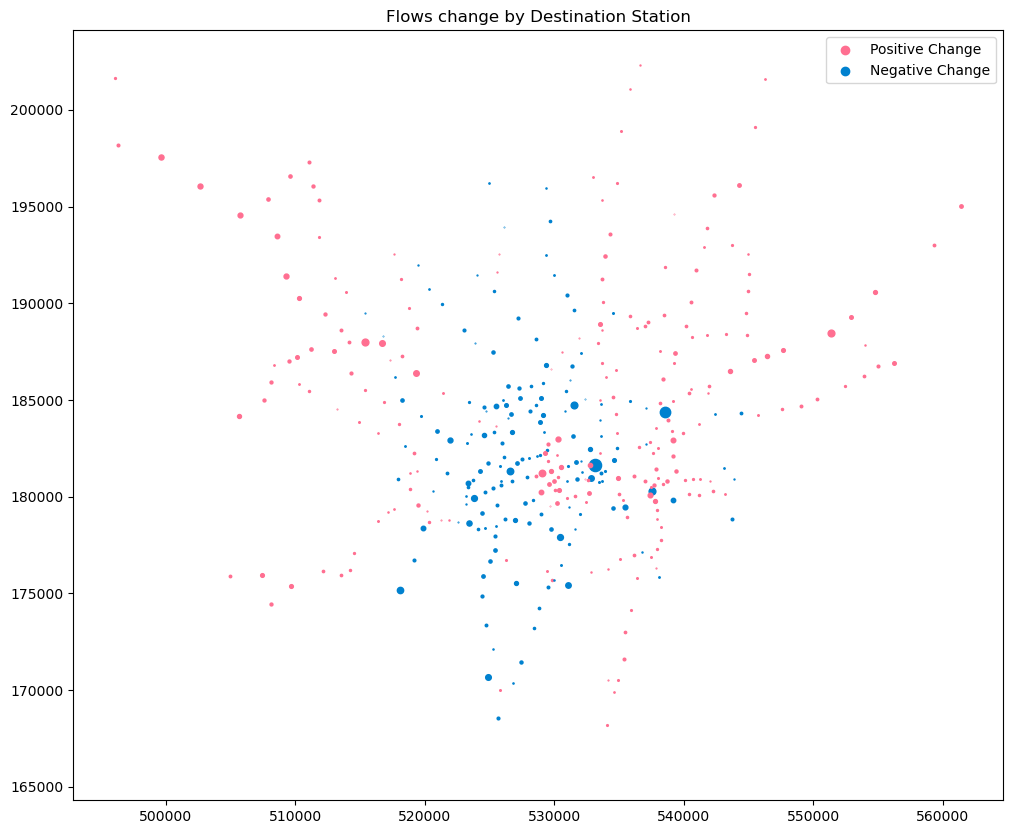

In [131]:
# Make a difference between the destination inflow before and after the scenario changes, and then visualize it.
df_cleaned_B_1_coords['change_B_1'] = df_cleaned_B_1_coords['scenario_B_1'] - df_cleaned_B_1_coords['origin_exp']

grouped = df_cleaned_B_1_coords.groupby('station_destination').agg(
    total_change_B_1=('change_B_1', 'sum'),
    destination_coords=('destination_coords', 'first')
)

plt.figure(figsize=(12, 10))

for idx, row in grouped.iterrows():
    total_change = row['total_change_B_1']
    coords = row['destination_coords']
    color = '#FF6F91' if total_change > 0 else '#0081CF'
    size = abs(total_change)*0.1

    plt.scatter(coords[0], coords[1], color=color, s=size)

plt.title('Flows change by Destination Station')
plt.grid(False)

plt.scatter([], [], color='#FF6F91', label='Positive Change')
plt.scatter([], [], color='#0081CF', label='Negative Change')
plt.legend()

plt.show()

In [124]:
df_cleaned_B_2_coords = add_station_coords(df_cleaned_B_2, G)

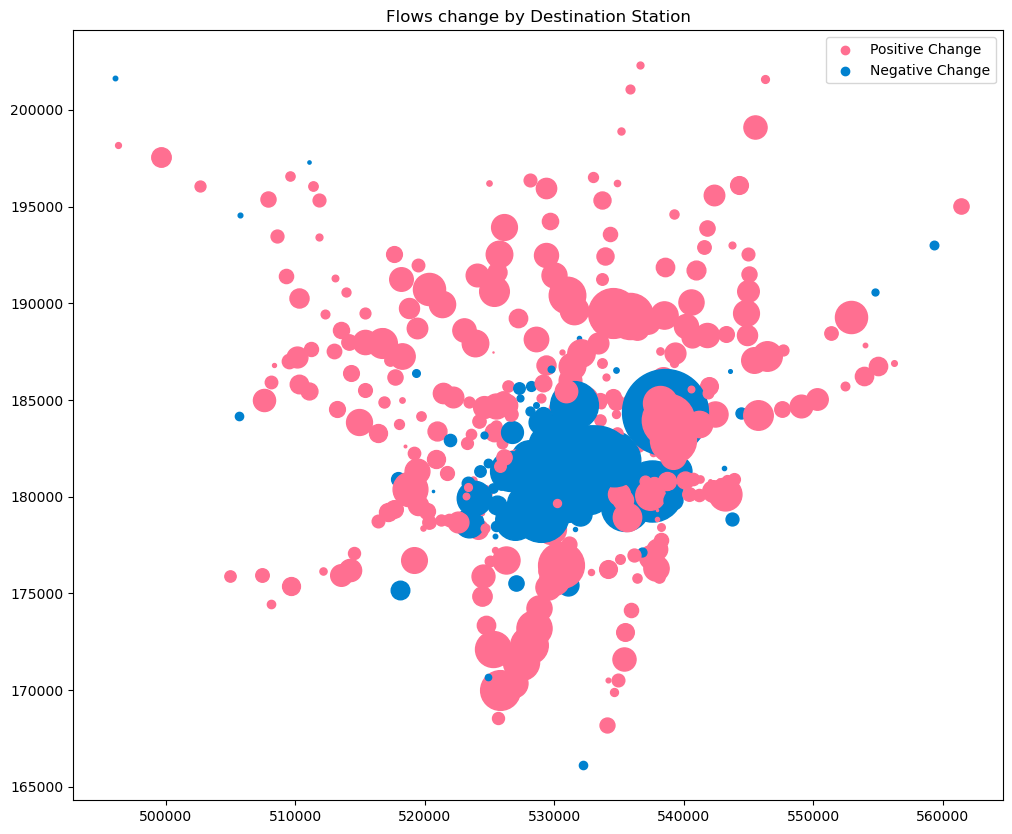

In [129]:
# Make a difference between the destination inflow before and after the scenario changes, and then visualize it.
df_cleaned_B_2_coords['change_B_2'] = df_cleaned_B_2_coords['scenario_B_2'] - df_cleaned_B_2_coords['origin_exp']

grouped = df_cleaned_B_2_coords.groupby('station_destination').agg(
    total_change_B_2=('change_B_2', 'sum'),
    destination_coords=('destination_coords', 'first')
)

plt.figure(figsize=(12, 10))

for idx, row in grouped.iterrows():
    total_change = row['total_change_B_2']
    coords = row['destination_coords']
    color = '#FF6F91' if total_change > 0 else '#0081CF'
    size = abs(total_change)*0.1

    plt.scatter(coords[0], coords[1], color=color, s=size)

plt.title('Flows change by Destination Station')
plt.grid(False)

plt.scatter([], [], color='#FF6F91', label='Positive Change')
plt.scatter([], [], color='#0081CF', label='Negative Change')
plt.legend()

plt.show()

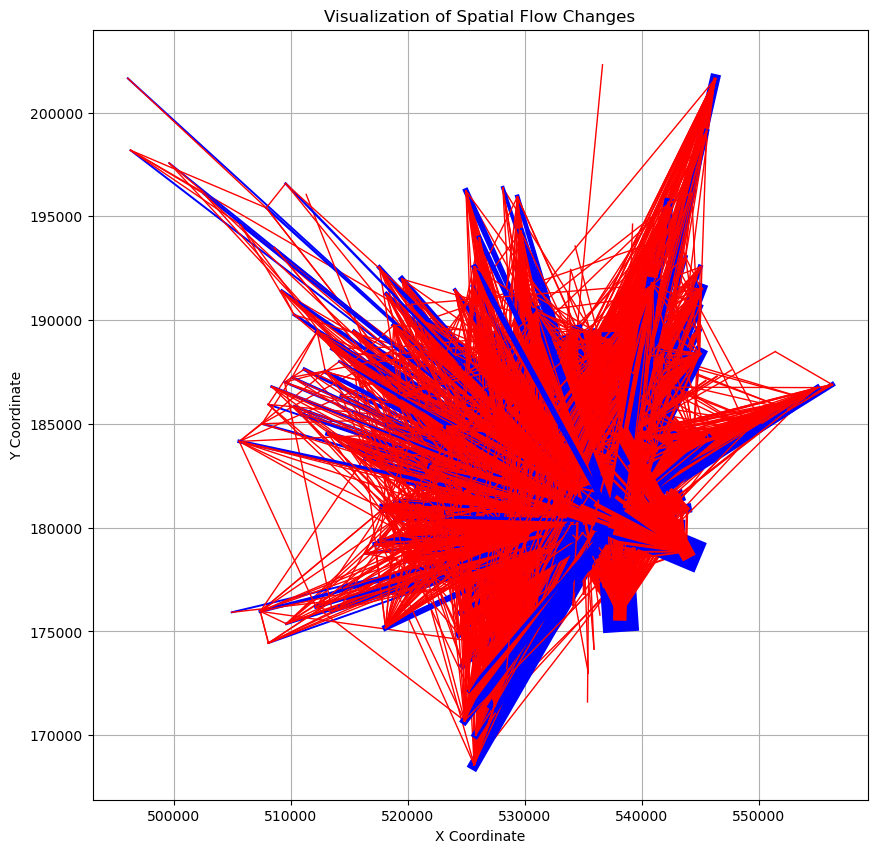

In [112]:
# Make a difference between the flows before and after the scenario changes, and then visualize it
df_cleaned_A_coords['change_A'] = df_cleaned_A_coords['scenario_A_1'] - df_cleaned_A_coords['origin_exp']

plt.figure(figsize=(10, 10))

for idx, row in df_cleaned_A_coords.iterrows():
    origin = row['origin_coords']
    destination = row['destination_coords']
    flow_change = row['change_A']
    
    # Draw the line only if the flow change is not 0
    if flow_change != 0:
        
        # Determines the color of the line: positive values are red, negative values are blue
        color = 'red' if flow_change > 0 else 'blue'
        
        # Determine line thickness
        linewidth = flow_change**0.5 if flow_change > 0 else (-flow_change)**0.5
        
        plt.plot([origin[0], destination[0]], [origin[1], destination[1]], color=color, linewidth=linewidth)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Visualization of Spatial Flow Changes')
plt.grid(True)

plt.show()